# **Preparing and Training the Sentiment analysis Model**

# *Import all the packges required*

In [1]:

from keras.models import Model, Sequential
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.initializers import glorot_uniform
from keras.preprocessing import text, sequence
from keras.regularizers import l2
from keras.constraints import maxnorm
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
import os
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import rcParams
from collections import Counter


import the pretrained word embeddings

In [2]:
!kaggle datasets download -d watts2/glove6b50dtxt

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [3]:
df=pd.read_csv('phone_reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17248 entries, 0 to 17247
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    17248 non-null  int64 
 1   mobile_names  17248 non-null  object
 2   asin          17248 non-null  object
 3   title         17248 non-null  object
 4   body          17248 non-null  object
 5   star          17248 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 808.6+ KB


In [4]:
df['star']-=1
x=df['body']
y=df['star']

Split the data of training and evaluating the model

In [5]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [6]:
sentence_lengths=X_train.apply(lambda x:len(x.split()))

In [7]:
sentence_lengths.describe()

count    13798.000000
mean        47.114727
std         54.091311
min          0.000000
25%         16.000000
50%         33.000000
75%         56.000000
max        778.000000
Name: body, dtype: float64

So, by the above we can take the the length of  the sentence as 100. 

# Hyperparameters

In [8]:
maxlen=100
loss='categorical_crossentropy'
batch_size=32
optimizer='adam'
epochs=10

In [9]:
#this code is imported from coursera sequential models assignment


def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


#convert number to one_hot vector
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


#sentences to word indices
def sentences_to_indices(X, word_to_index):  
    m = X.shape[0]                                   # number of training examples

   
    X_indices = np.zeros(m)
    X_indices=[]
    for i in range(m):                               # loop over training examples

        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']
        #sentence_words=X[i].split(' ')
        # Initialize j to 0
        j=0
        
        # Loop over the words of sentence_words
        li=np.zeros(len(sentence_words))
        for w in sentence_words:
            
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                li[j] = word_to_index[w]
            except:
               # print(w)
                li[j]= 0
            # Increment j to j + 1
            j += 1
        X_indices.append(li)    
    X_indices=np.array(X_indices)
    return X_indices


def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1              
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
   

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [10]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../input/glove6b50dtxt/glove.6B.50d.txt')

#test
word = "good"
idx = 567
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of good in the vocabulary is 164328
the 567th word in the vocabulary is ,6


In [11]:
X1 = np.array(["the phone is good", "very bad", "no star rating"])
X1_indices = sentences_to_indices(X1,word_to_index)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['the phone is good' 'very bad' 'no star rating']
X1_indices =
 [array([357266., 283483., 192973., 164328.]) array([377946.,  65963.])
 array([262350., 341678., 301038.])]


In [12]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


Building the Model of 2 layers of LSTM

In [13]:
def lstmModel(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5, activation=None)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)
    
    return model

In [14]:
model = lstmModel((100,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          91648     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                

In [15]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

**Prepare the data for training**

In [16]:
X_train_np=np.array(X_train)
y_train_np=np.array(y_train)
X_test_np=np.array(X_test)
y_test_np=np.array(y_test)

Y_train_oh = convert_to_one_hot(y_train_np, C = 5)
Y_test_oh = convert_to_one_hot(y_test_np, C = 5)

X_test_indices = sentences_to_indices(X_test_np, word_to_index)
X_train_indices = sentences_to_indices(X_train_np, word_to_index)

X_train_indices = sequence.pad_sequences(X_train_indices, maxlen=100)
X_test_indices = sequence.pad_sequences(X_test_indices, maxlen=100)

In [17]:
model_history=model.fit(X_train_indices, Y_train_oh, epochs = epochs, batch_size = batch_size, shuffle=True)

Epoch 1/5
432/432 [==============================] - 5s 12ms/step - loss: 0.9950 - accuracy: 0.6353
Epoch 2/5
432/432 [==============================] - 5s 12ms/step - loss: 0.5263 - accuracy: 0.8188
Epoch 3/5
432/432 [==============================] - 5s 12ms/step - loss: 0.2623 - accuracy: 0.9143
Epoch 4/5
432/432 [==============================] - 5s 12ms/step - loss: 0.1524 - accuracy: 0.9525
Epoch 5/5
432/432 [==============================] - 6s 13ms/step - loss: 0.1044 - accuracy: 0.9669


In [18]:
test_preds=model.predict(X_test_indices)
test_preds = [np.argmax(pred) for pred in test_preds]
train_preds=model.predict(X_train_indices)
train_preds = [np.argmax(pred) for pred in train_preds]

In [19]:
from sklearn.metrics import cohen_kappa_score,accuracy_score
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds, y_test.astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(y_test.astype('int'),test_preds))
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, y_train.astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(y_train.astype('int'),train_preds))

Train Cohen Kappa score: 0.979
Train Accuracy score : 0.977
Train Cohen Kappa score: 0.984
Train Accuracy score : 0.978


In [20]:
def sentiment_category(score):
    if score >= 4:
        return "positive"
    elif score <= 2:
        return "negative"
    else:
        return "neutral"

In [21]:

df_indices = sentences_to_indices(np.array(df['body']), word_to_index)
df_indices = sequence.pad_sequences(df_indices, maxlen=100)
df_preds=model.predict(df_indices)
df_preds = [np.argmax(pred) for pred in df_preds]
df['sentiment_score']=df_preds
df['review_category']=df['sentiment_score'].apply(lambda x:sentiment_category(x))

Text(0.5, 1.0, 'Distribution of Reviews Category')

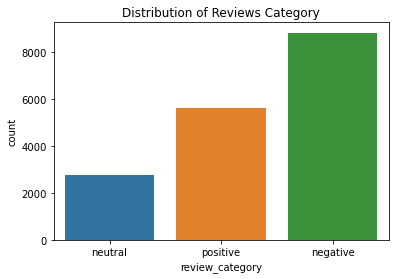

In [22]:
sns.countplot(df['review_category']).set_title("Distribution of Reviews Category")

In [23]:
positive_reviews=df.loc[df['review_category']=='positive','body'].tolist() # extracting all positive reviews and converting to a list
positive_reviews[0:5]

[' title obviously monsterand good performance',
 ' brilliant camera huge battery life brilliant display addition premium feeling samsung shame phones launch delayed due lockdownhighly recommended phone ',
 ' love one best class no1 best budget mobile samsung mobile brand also global no1 brand world great one rating 5star thanks samsung n amazon',
 ' value moneyi gamer cant say gaming performance buying normal usage phone great 6gb ram128 gb internal storage amoled display satisfiedi using samsung phones start samsungs amoled screen attracted feel gives simply amazingbut battery dont seem 6000 mahas far non gamer concerned phone best price range',
 ' nice mobile good']

In [24]:
negative_reviews=df.loc[df['review_category']=='negative','body'].tolist() # extracting all negative reviews and converting to a list
negative_reviews[0:5]

[' writing review using 6 daysi bought sumsung phone 7 years hoping could good phone samsung disappointed lotthey claim 6000mah battery drain like 3000mah take almost 230hrs charge 10 90 fast charging fast charging market gimic clail monester like features iebattery 6000mah 15w fast charge ete reality far far away claimsothers features per price range thinking battery packed phone fast chargethen would sugget plz search others phone range',
 ' defective product received gets 8 12 hours charging amazon exchanging product',
 ' poor performance hangs aloft even dont use gaming app browsing phone lacks inspite 6 gb ram product serves zero rating please dont buy wastage money refund policy device',
 ' writing review using 6 daysi bought sumsung phone 7 years hoping could good phone samsung disappointed lotthey claim 6000mah battery drain like 3000mah take almost 230hrs charge 10 90 fast charging fast charging market gimic clail monester like features iebattery 6000mah 15w fast charge ete re

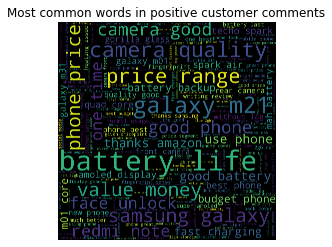

In [25]:

wordcloud = WordCloud(height=4000, width=4000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df.loc[df['review_category']=='positive','body'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in positive customer comments")
plt.axis('off')
plt.show()

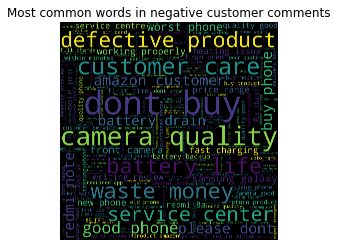

In [26]:
from wordcloud import WordCloud
wordcloud = WordCloud(height=4000, width=4000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df.loc[df['review_category']=='negative','body'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in negative customer comments")
plt.axis('off')
plt.show()

*Note:* There are some words that should not be there such as "galaxym21,samsung galaxy,redmi note"

# Generating Bigrams
Bigrams are more effective than unigrams

In [27]:
def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn)

In [28]:
def generateNGram(text,n):
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams]

In [29]:
positive_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in positive_reviews]
negative_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in negative_reviews]

In [30]:
def plotMostCommonWords(reviews_list,topn=30,title="Common Review Words",color="blue",axis=None): #default number of words is given as 30
    top_words=getMostCommon(reviews_list,topn=topn)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(topn))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(topn))

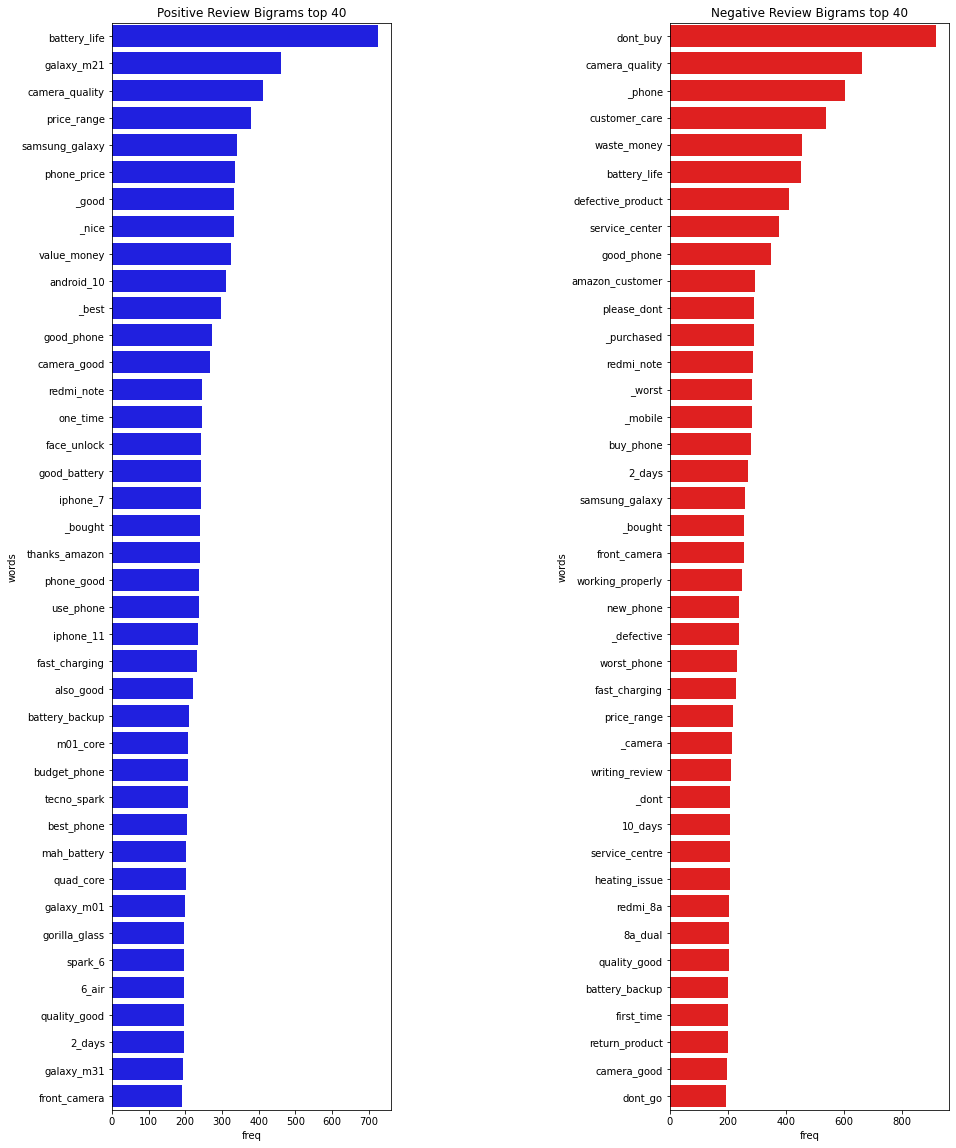

In [31]:
rcParams['figure.figsize'] = 15,20
fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=1)
plotMostCommonWords(positive_reviews_bigrams,40,'Positive Review Bigrams',axis=ax[0])

plotMostCommonWords(negative_reviews_bigrams,40,'Negative Review Bigrams',color="red",axis=ax[1])